# Ensemble methods

In [32]:
# INSTALL PACKAGES
%pip install graphviz seaborn xgboost pdpbox lime imblearn sklearn scikit-optimize

import time
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from IPython.display import display

from pdpbox import pdp, get_dataset, info_plots
from lime.lime_tabular import LimeTabularExplainer
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
                             auc, precision_recall_curve, make_scorer, confusion_matrix, plot_roc_curve)

# Importing the cleaned data
df = pd.read_csv('stroke_clean.csv', index_col='id')
print('Dataset: ', df.shape)
df.head()


Dataset:  (4908, 18)


,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,govt_job,never_worked,private,self-employed,children,never_smoked,formerly_smoked,smokes,unknown_smoker,stroke
id,,,,,,,,,,,,,,,,,,
9046,0,67.0,0,1,1,1,228.69,36.6,0,0,1,0,0,0,1,0,0,1
31112,0,80.0,0,1,1,0,105.92,32.5,0,0,1,0,0,1,0,0,0,1
60182,1,49.0,0,0,1,1,171.23,34.4,0,0,1,0,0,0,0,1,0,1
1665,1,79.0,1,0,1,0,174.12,24.0,0,0,0,1,0,1,0,0,0,1
56669,0,81.0,0,0,1,1,186.21,29.0,0,0,1,0,0,0,1,0,0,1


In [33]:
# Do a train-test split
x = np.array(df.loc[:, df.columns != 'stroke'])
y = np.array(df['stroke'])
test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 41)

### Introduction

The aim of this project is correctly classifying cases of stroke, as well as trying to explain which features are most important in the prediction and how these features affect the oucome of the models. The dataset we have chosen has a very skewed class distribution, meaning that we must think carefully about what metrics to use for the model evaluation and what types of methods are best suited for such an imbalanced classification problem. We are first going to do some quick data exploration to understand the dataset, before we apply several different ensemble methods and a neural network. Hyperparameter tuning will be done with both gridsearch and Bayesian optimization. We will also utilize both global and local methods to try to explain the outcomes of our prediction models. Given that we have around 5000 observations after cleaning the dataset, we consider this enough data to split the set into a training set (70%) and a test set (30%).

### Exploratory data analysis

After cleaning the data we do some quickly analysis of it to understand some of the underlying trends.

In [34]:
print("Percentage of stroke examples in dataset: ", np.round(df[df.stroke == 1].shape[0]/df.shape[0]*100, 2), "%")
print("Percentage of non-stroke examples in dataset: ", np.round(df[df.stroke == 0].shape[0]/df.shape[0]*100, 2), "%")

Percentage of stroke examples in dataset:  4.26 %
Percentage of non-stroke examples in dataset:  95.74 %


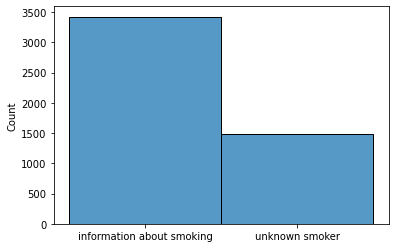

In [35]:
d = np.where(df.unknown_smoker == 1, "unknown smoker", "information about smoking")
sns.histplot(data = d)
plt.show()

We see that almost one third of our data has smoking status unknown. This is a lot of data, so we coose to include the data with unkown smoking status in our analysis. 

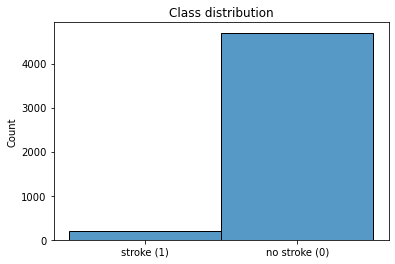

In [36]:
d = np.where(df.stroke == 1, "stroke (1)", "no stroke (0)")
sns.histplot(data = d).set_title("Class distribution")
plt.show()

We see that the class distribution is very skewed, which will make this a hard problem, as the model must be sensitive enough to capture the trends of the minority class. We try looking at the stroke distribution among some of the other features in the dataset.

Text(0.5, 1.0, 'Gender/stroke distribution')

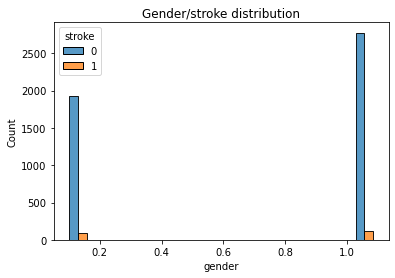

In [37]:
sns.histplot(data=df, x="gender", hue="stroke", multiple="dodge", shrink=.8).set_title("Gender/stroke distribution")

We see that we have more females than males in the dataset, but that the number of strokes in the two groups seems to be representative for the group size.

Text(0.5, 1.0, 'Age/stroke distribution')

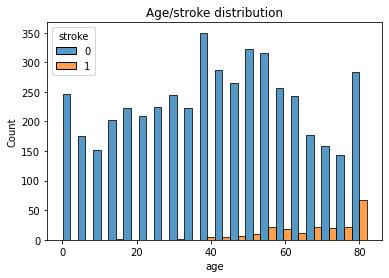

In [38]:
sns.histplot(data = df, x="age", hue="stroke", multiple="dodge").set_title("Age/stroke distribution")

We see that more old people than young people have strokes, while we seem to have a good representation of all ages in the dataset. It is not farfetched to assume that age will have an important role in the classification problem.

Text(0.5, 1.0, 'Bmi/stroke distribution')

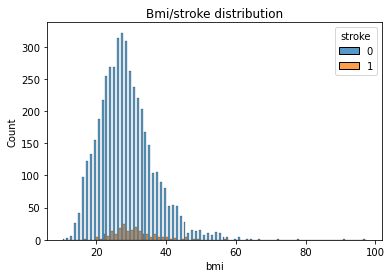

In [39]:
sns.histplot(data = df, x="bmi", hue="stroke", multiple="dodge").set_title("Bmi/stroke distribution")

Text(0.5, 1.0, 'Avg_glucaose_level/stroke distribution')

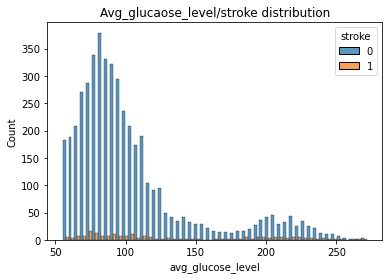

In [40]:
sns.histplot(data=df, x="avg_glucose_level", hue="stroke", multiple="dodge").set_title("Avg_glucaose_level/stroke distribution")

Text(0.5, 1.0, 'Hypertension/stroke distribution')

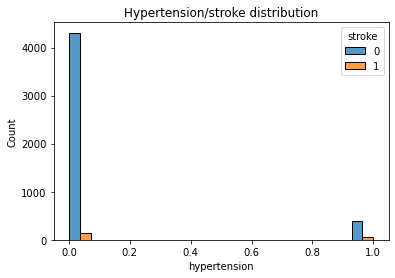

In [41]:
sns.histplot(data = df, x="hypertension", hue="stroke", multiple="dodge").set_title("Hypertension/stroke distribution")

For bmi, avg_glucose_level and hypertension it is difficult to see any clear patterns just from the graphs.

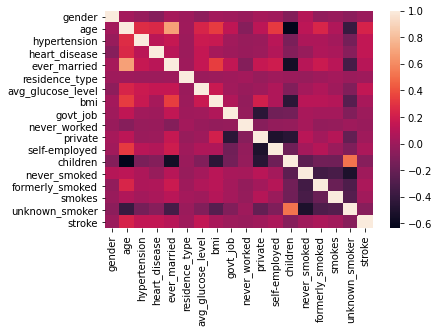

In [42]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix)
plt.show()

We also look at the correlation between the features. We see that the response stroke does not seems particularily correlated with any of the features. Thus the choice of non-linear models such as ensembles and neural networks is well motivated.

## Evaluating performance

In this binary classification problem we are dealing with a very imbalanced dataset. The majority class has 96% of the observations, while the minority class only has 4%. This is typical in medical datasets that deals with prediction of rare occurrences like stroke. We will always have many more examples of people without the condition, than with, making it very dificult to correctly identify the general pattern behind the minority class. In addition, with skewed medical datasets like this one, false negative rates and false positive rates do not have equal weight. In our dataset, a false negative will be much more dangerous than a false positive, as it is better to predict that someone will get a stroke and get it wrong, than the other way around.

For binary classification problems it is typical to use accuracy as the metric to evaluate performance of the method. Accuracy is the ratio of the correctly predicted observations to the total number of observation. With an imbalanced problem like the one we have, accuracy will not be a good preformance measure. To show why, if we simply make a classification model which predicts all observations as class 0, "no stroke", we will get a very high accuracy which will not reflect the difference in size between the two classes.

\begin{align*}
    \text{accuracy} = \frac{\text{tp + tn}}{\text{tp + tn + fn + fp}} = \frac{4699 + 0}{4699 + 0 + 209 + 0} = 0.957
\end{align*}

Other measures which are better with dealing with unsymmetric classes are precision and recall. Precision is the ratio of correctly predicted positive observations to the total number of predicted positive observations. Precision favors a low false positive rate. Recall is the ratio of correctly predicted positive observations to all the observations in the actual class. This favors the false negative rate, which is important when we want to minimize the number of false negatives. Both of these metrics would becomes zero in the case above.

\begin{align*}
    \text{precision} = \frac{\text{tp}}{\text{tp + fp}}, \quad \text{recall} = \frac{\text{tp}}{\text{tp + fn}}
\end{align*}

To be able to take into account both recall and precision, we can use the f1-measure, which is the harmoic mean of precision and recall:

\begin{align*}
    \text{f1} = \frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision + recall}}
\end{align*}

Instead of using the predicted values from using the threshold 0.5, we could also calculate both ROC-AUC and precision-recall-AUC to find better thresholds. ROC-AUC is the area under the ROC curve which plots the true positive rate against the false positive rate. The precision-recall curve uses precision instead of false positive rate, and can be considered better in the case when we have an unproportional large amount of true negatives, since neither recall or precision takes this into account.

Sklearn also icludes several metric which tries to balance out the classes during evaluation. For evaluating our models we will use the balanced accuracy score, which is defined as the average of recall obtained on each class: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html, and we will show this produces good results. Using this metric during the hyperparameter tuning of the models, the goal is that the models will favor decreasing the amount of false negatives over increasing the amount of true negatives. This might push more observations into false positives, but considering the real world implications of false negatives in stroke predictions, this is an acceptable trade-off.


In [82]:
# Necessary functions for evaluating models

def curves(model_fit, x_test, y_test):
    baseline_probs = [0 for _ in range(len(y_test))]
    probs = model_fit.predict_proba(x_test)[:, 1]

    # calculate scores
    baseline_auc = roc_auc_score(y_test, baseline_probs)
    pc_auc = roc_auc_score(y_test, probs)

    # calculate roc curves
    baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs, drop_intermediate = False)
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    
    axs[0].plot(baseline_fpr, baseline_tpr, linestyle = "--", color = "lightgrey")
    axs[0].plot(fpr, tpr, marker = ".", label = "ROC AUC=%.3f" % (pc_auc), color = "orange")
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC Curve")
    axs[0].legend()
    
    # Calculating precision-recall curves
    probs = model_fit.predict_proba(x_test)[:, 1]
    
    # predict class values
    precision, recall, _ = precision_recall_curve(y_test, probs)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    yhat = model_fit.predict(x_test)
    model_f1, model_auc = f1_score(y_test, yhat), auc(recall, precision)
    
    axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', color = "lightgray")
    axs[1].plot(recall, precision, marker=".", label="f1=%.3f auc=%.3f" % (model_f1, model_auc), color = "orange")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].set_title("Precision-Recall Curve")
    axs[1].legend()
    
    plt.show()

def train_error(model_fit):
    train_pred = model_fit.predict(x_train)

    print("Train errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_train, train_pred))
    print("precision: %.3f" % precision_score(y_train, train_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_train, train_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_train, train_pred, zero_division = 0))
    print()
    
def test_error(model_fit):
    test_pred = model_fit.predict(X_test)

    print("Test errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_test, test_pred))
    print("precision: %.3f" % precision_score(y_test, test_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_test, test_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_test, test_pred, zero_division = 0))

    cm_test = confusion_matrix(y_test, test_pred)
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cm_test.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm_test, annot=labels, fmt = "", annot_kws={"size": 16}, linewidths = 0.5, cmap="YlGnBu")

In [44]:
metric = "balanced_accuracy"

## Hyperparameter tuning
Most of the models we will apply will need some hyperparameter tuning in order to be effective. Hyperparameters are essentially all parameters that we pass to the function that fits a model. What we consider hyperparameters will become evident when discussing the different models. The goal of hyperparameter tuning is to select hyperparameters so that the model maximizes some metric. For essentially all models we use the "balanced_accuracy" metric for tuning our models. 

In statistical learning and machine learning, the the hope is that most model are stable in the hyperparameters, meaning that small changes in hyperparameters yield similar results. This is however not always the case, and hyperparameter tuning is necessary.

Different hyperparameters also allow us to tune models to be more balanced. However, we will see that in order to get good results for this problem, one should start with a balanced model instead of tuning an unbalanced model to be more balanced. 

Hyperparameter tuning is a difficult optimization problem. It is difficult because we usually have no mathematical expression for how different hyperparameters affect the metric. This means that we have no information about gradients, and the problem is most likely non-convex. Furthermore, function evaluations, which here corresponds to fitting a model with certain hyperparameters, are usually expensive. For tree-models, many hyperparameters are discrete, and if we change one hyperparameter we usually have to refit the entire model. This is different from for example lasso regression, where model fits are (usually) continuous with respect to the regularization parameter, and one fit can be used to quickly find the next fit. This is also the case for some tree-model hyperparameters, but this is not necessarily taken into account by the methods we use to search for hyperparameters. 

We will use two different methods for hyperparameter tuning: Grid search and Bayesian search. 
Grid search fits models using a grid of hyperparameters, at each point applying CV to get an estimate of the metric, and selects the model that gives the best result. 

- Grid search is simple, easy to parallelize and requires essentially no cost other than fitting the models.
- One of the drawbacks is that we have to preselect a grid, which can either be too coarse, leading to a bad result, or too fine, leading to long computation times. 
- Another problem with preselecting a grid is that the optimal hyperparameters do not necessarily lie inside the preselected grid, meaning that grid search is not entirely automatic.

The grid search we will use is the ```GridSearchCV``` function in the sklearn library. 

Bayesian search uses Bayesian optimization to find optimal hyperparameters. We will not go into detail about Bayesian optimization here, but we will mention some pros and cons. 

- The main appeal of Bayesian optimization is that it searches for a good solution in a much smarter way than grid search. 
- It is able to handle local minimizers, which is something traditional optimization methods usually struggle with.
- We can select prior distributions for the hyperparameters, and the result can be considered a posterior distribution. Thus, we can actually do some inference with our hyperparameters.
- The implementation that we will use, ```BayesianSearchCV``` from the scikit optimize library, is currently under development, and not particularily fast or well-documented. The extra cost of searching for good hyperparameters to test most likely outweigh the cost of just testing more "bad" hyperparameters, which is especially the case if fitting the models is cheap. 
- Bayesian optimization is also mainly effective for continuous, not discrete, variables. It is unknown to us how the implementation we use handles discrete variables. Bayesian optimization also has the problem of requiring a preselected grid where we search for solutions.

For both grid search and Bayesian search, the implementations we are using are rather lacking in that it is difficult to interpret the results. It is not impossible, but it requires some extra work that we are not interested in doing here. It would be interesting to investigate how stable different methods are with respect to different hyperparameters and which hyperparameters are important.

### Logistic Regression
The first model we will try is logistic regression with ridge penalty. We also set the ```class_weight``` to "balanced". Using the keyword "balanced" the method will automatically adjust weights which are inversely proportional to the class frequencies in the input data. We will get back to this more with random forests.

One of the nice things about logistic regression is that we only need to tune the ridge parameter, which is done done a lot more effectively than the parameter tuning for the other methods.

Time used for fitting:  3.099095106124878  seconds


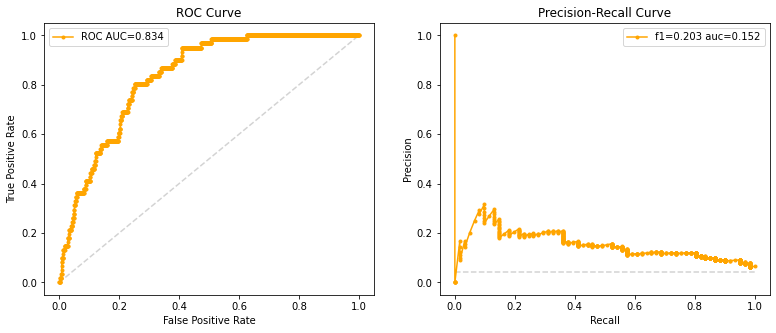

Test errors:

accuracy: 0.739
precision: 0.116
recall: 0.803
f1: 0.203


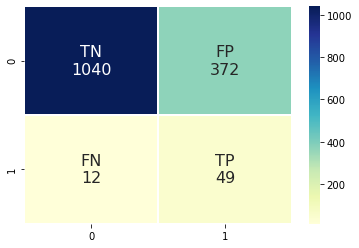

In [45]:
t = time.time()

logregfit = LogisticRegressionCV(random_state=0, max_iter = 1000, penalty='l2', 
                                 cv = 10, class_weight = "balanced").fit(x_train, y_train)

print("Time used for fitting: ", time.time() - t, " seconds")

curves(logregfit, x_test,y_test)

test_error(model_fit = logregfit)

Investigating the ROC-curve we see that even when using the "balanced" weighting the curve is skewed towards the upper right, indicating that true positives comes heavily at the cost of false positives. This is mainly because our dataset is unbalanced, and we will see this for essentially all models.

### Decision tree

For tree-based models, we start by implementing a simple decision tree to get a baseline test error for our models to see if the more advanced ensemble methods and the neural network can actually improve predictions for this very imbalanced dataset. To search for the optimal hyperparameters we use a gridsearch using sklearn's $```GridSearchCV```$. To use this method we must define a grid of hyperparameter values for the method to test.  For the decision tree we decide to include the hyperparamters ```criterion```, ```max_depth```, ```min_samples_split``` and ```min_samples_leaf```. There are more hyperparameters to tune, and we are not certain if these are the best parameters to tune. In fact, the more parameters we tune, the more likely it is that we do a lot of unecessary calculations.

We will first implement the decision tree using accuracy as the scoring metric, to show that this does not yield optimal results.

In [46]:
parameters = {"criterion": ["gini", "entropy"], "max_depth": range(1, 8, 1),          # The maximum depth of the tree
              "min_samples_split": range(2, 8, 1),  # The minimum number of samples required to split an internal node
              "min_samples_leaf": range(1, 8, 1)}   # The minimum number of samples required to be at a leaf node

t = time.time()

decisiontree = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 23),
                   param_grid = parameters,
                   scoring = "accuracy",
                   n_jobs = 8, # number of jobs should be equal to number of threads on machine
                   cv = 3)
decisiontreefit = decisiontree.fit(x_train, y_train)

print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameter:")
print(decisiontreefit.best_params_)

Time used for fitting:  8.549135684967041  seconds
Best hyperparameter:
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [47]:

#tree = DecisionTreeClassifier(**best_params, criterion = "gini", random_state = 23)
#tree_fit = tree.fit(x_train, y_train)

## THIS IS BUGGED, SHOULD JUST REMOVE
#display(graphviz.Source(export_graphviz(tree_fit, feature_names = df.columns[:-1], filled = True, class_names = ("no stroke", "stroke"))))

We see that the best hyperparameters yield an extremely shallow tree with a maximum depth of 1. From the resulting decision tree above we see that the tree does not manage to correctly classify many of the observations from the minority class. We calculate the test error below.

Test errors:

accuracy: 0.959
precision: 0.000
recall: 0.000
f1: 0.000


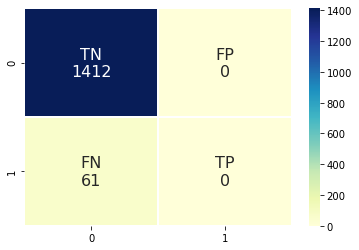

In [48]:
test_error(model_fit = decisiontreefit)

From the confusion matrix above we see that the method does not manage to predict a single true positive case, but still gets a accuracy of $\sim 96\%$. As the good statisticians we are, we are not fooled by the good accuracy, and try use the "balanced accuracy" as the scoring metric in the hyperparameter tuning from now on.

For each model we also plot the ROC and precision-recall curves to see how these changes with the different methods. When using a different metric we expect the ROC-AUC score to becomes worse, but hopefully the PR-AUC score will increase.

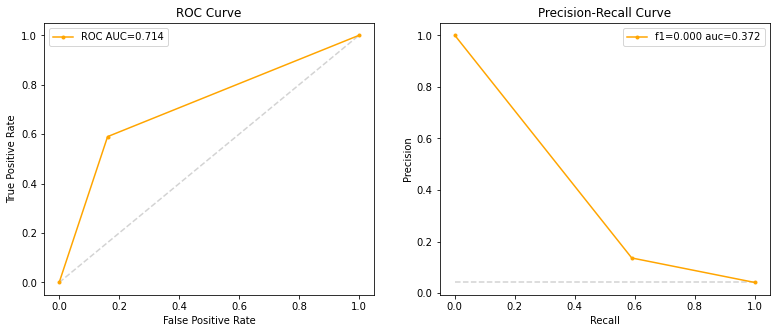

In [49]:
curves(model_fit = decisiontreefit, x_test = x_test, y_test = y_test)

We train the decision tree again, this time with the "balanced accuracy" score. We also allow the ```class_weight``` to be "balanced" in out hyperparameter tuning.

In [50]:
parameters = {"criterion": ["gini", "entropy"], "max_depth": range(1, 8, 1),          # The maximum depth of the tree
              "min_samples_split": range(2, 8, 1),  # The minimum number of samples required to split an internal node
              "min_samples_leaf": range(1, 8, 1),   # The minimum number of samples required to be at a leaf node
              "class_weight": [None, "balanced"]}

t = time.time()

bdecisiontree = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 23),
                   param_grid = parameters,
                   scoring = metric, # <- balanced_accuracy metric
                   n_jobs = 8,
                   cv = 3)

bdecisiontreefit = bdecisiontree.fit(x_train, y_train)

print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameters:")
print(bdecisiontreefit.best_params_)

#display(graphviz.Source(export_graphviz(tree_fit, feature_names = df.columns[:-1], filled = True, class_names = ("no stroke", "stroke"))))

Time used for fitting:  8.208045721054077  seconds
Best hyperparameters:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Test errors:

accuracy: 0.633
precision: 0.090
recall: 0.869
f1: 0.164


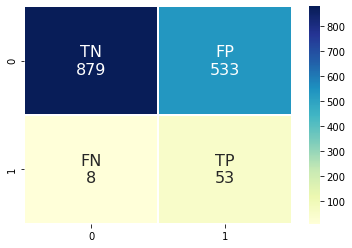

In [51]:
test_error(model_fit = bdecisiontree)

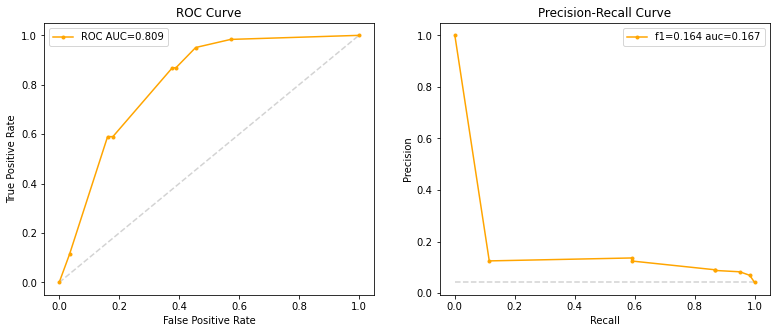

In [52]:
curves(model_fit = bdecisiontree, x_test = x_test, y_test = y_test)

Using the different scoring metric, we have managed to get a better recall, at the expense of many more false positive predictions and a much lower accuracy. Being able to classify true positives comes heavily at the cost of producing false negatives. We see from the hyperparameter tuning that a deeper tree is now necessary. 

### Random Forest

Instead of using a single decision tree, we instead try a random forest model. Random Forest is a modification of bagging which tries to reduce the variance further by decreasing the correlation between the trees by including randomness in which features to consider for each split in each tree. The hyperparameters we will tune are the number of trees in the forest, ```n_estimators```, the number of features to consider in each split, ```max_features```, and the ```max_depth``` of the trees. In this case, we look at a sparser grid of hyperparameters. As the number of hyperparameters increase, the number of fits required by a grid search increases quickly. In this example, we have to test $360$ different fits.

In [53]:
parameters = {'criterion': ['gini', 'entropy'], 
              'n_estimators': [1, 5, 10, 30, 50, 100],
              'max_features': ('sqrt', 8, 12),
              'max_depth': range(1, 10, 1)}

t = time.time()

randomforest = GridSearchCV(estimator = RandomForestClassifier(random_state = 23,
                                                      bootstrap = True),
                  param_grid = parameters,
                  scoring = metric,
                  n_jobs = 8, 
                  cv = 3)
randomforestfit = randomforest.fit(x_train, y_train)

print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameters:")
print(randomforestfit.best_params_)

Time used for fitting:  31.452877044677734  seconds
Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 12, 'n_estimators': 1}


Test errors:

accuracy: 0.950
precision: 0.071
recall: 0.016
f1: 0.027


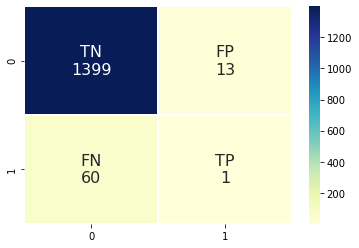

In [54]:
test_error(model_fit = randomforest)

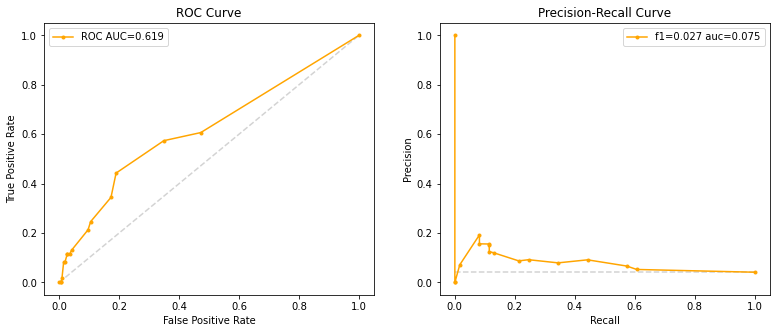

In [55]:
curves(model_fit = randomforest, x_test = x_test, y_test = y_test)

From the results above we see that the random forest does not work exactly as we hoped. From the cross-validation grid search we see that the model favors only a single decision tree, which is deep and includes the choice of many features for each split. The reason why the method fails is probably because it is hard to find a shallow tree which manages to predict anything other than the majority class. During the bootstrapping procedure, we expect even fewer examples from the minority class to be present during the fitting of the model. This is probably why the model fails and would rather build fewer deeper trees, than a whole forests of small ones. This shows that we cannot tune an unbalanced model to become balanced. The method needs to be balanced to begin with. This motives the use for better sampling during the bootstrap which leads to weighted random forest and balanced random forest.

### Weighted Random Forest

From the above result it is obvious that we have to change the random forest algorithm to make it more sensitive towards misclassifications of the minority class. One way to do this is by giving the different classes different weights when calculating the gini impurity score at each split. This way the model becomes better at making splits which favors correctly classifying the minority class. Sklearn's implementation of random forest includes the parameter class_weight which can be used for this purpose. As mentioned earlier we can use the ```class_weight``` "balanced" in this case. Since we are using bootstrap samples we can also use the keyword "balanced_subsample" which computes the weights based on the distribution of the classes in each bootstrap sample.

In [56]:
parameters = {'n_estimators': [1, 10, 30, 50, 100],
              'max_features': ('sqrt', 8, 12),
              'max_depth': range(1, 10, 1),
              'class_weight': ["balanced", "balanced_subsampled"]}

t = time.time()

wrandomforest = GridSearchCV(estimator = RandomForestClassifier(random_state = 23, criterion= 'gini',
                                                      bootstrap = True),
                  param_grid = parameters,
                  scoring = metric,
                  n_jobs = 8,
                  cv = 3)
wrandomforestfit = wrandomforest.fit(x_train, y_train)

print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameters:")
print(wrandomforest.best_params_)

Time used for fitting:  16.403128385543823  seconds
Best hyperparameters:
{'class_weight': 'balanced', 'max_depth': 3, 'max_features': 8, 'n_estimators': 30}


Test errors:

accuracy: 0.695
precision: 0.099
recall: 0.787
f1: 0.176


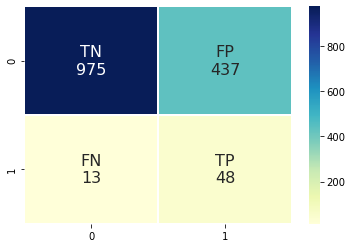

In [57]:
test_error(model_fit = wrandomforest)

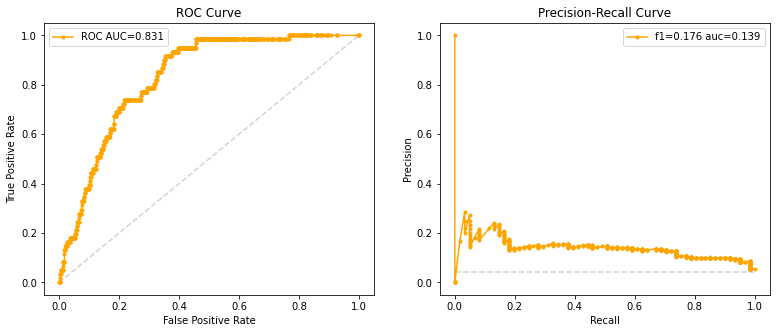

In [58]:
curves(model_fit = wrandomforest, x_test = x_test, y_test = y_test)

Using the Weighted Random Forest we acheive the best ROC-AUC and PR-AUC so far. We see that we have managed to decrease the number of false negatives significantly, but as a result the number of false positives has increased dramatically.

### Balanced Random Forest

Another method we can use to make the random forest more sensitive to the minority class is to use under-/oversampling during the bootstrap sampling. Oversampling works by sampling more observation from the minority class by either duplicating or creating new synthetic observations, such that the occurrence of minority observations is more balanced compare with the majority class. Undersampling works by deleting or merging examples in the majority class. 

The Python library imbalanced-learn offers a number of resampling techniques which can be used in datasets showing strong imbalance. It includes an implementation of the Balanced Random Forest methods, which works by randomly undersampling from the majority class during the bootstrap sampling: https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html. We hope that this will bring an even bigger improvement to the method than using the Weighted Random Forest.

In [59]:
parameters = {'n_estimators': [1, 10, 30, 50, 100],
              'max_features': ('sqrt', 8, 12),
              'max_depth': range(1, 10, 1),
              'class_weight': [None, "balanced", "balanced_subsampled"]}

t = time.time()

brandomforest = GridSearchCV(estimator = BalancedRandomForestClassifier(random_state = 23,
                                                              criterion= 'gini',
                                                              bootstrap = True),
                  param_grid = parameters,
                  scoring = metric,
                  n_jobs = 8, 
                  cv = 3)

brandomforestfit = brandomforest.fit(x_train, y_train)

print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameters:")
print(brandomforest.best_params_)

Time used for fitting:  34.46178889274597  seconds
Best hyperparameters:
{'class_weight': None, 'max_depth': 7, 'max_features': 12, 'n_estimators': 30}


Test errors:

accuracy: 0.721
precision: 0.111
recall: 0.820
f1: 0.196


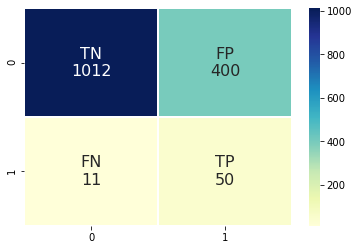

In [60]:
test_error(model_fit = brandomforest)

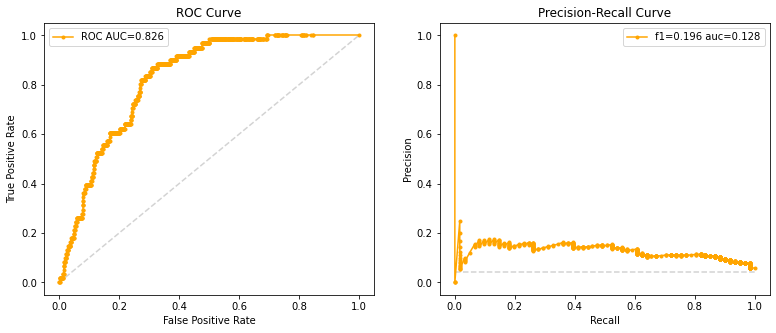

In [61]:
curves(model_fit = brandomforest, x_test = x_test, y_test = y_test)

The balanced random forest yields better results than the weighted random forest. This comes at the cost of $2-3$ times the computational cost. We can note that the balanced random forest prefers deep trees.

Considering balanced random forest seems to have the largest potential, we also try to apply Bayesian search to fine tune the parameters further. For Bayes search, we can search for all hyperparameters in a certain range, not just a preselected grid. For consistency, we select hyperparameters in the same range as for grid search. For the implementation we are using, there is no automatic termination, meaning we have to preselect the number of iterations used in the algorithm. We select the number of iterations to be $256$.

In [62]:
from skopt.space import Real, Categorical, Integer

search_space= {'max_depth': Integer(1,10),          # The maximum depth of the tree
              'n_estimators': Integer(1,100),
              'max_features': Integer(1,12)}

t = time.time()

brandomforestBS = BayesSearchCV(estimator=BalancedRandomForestClassifier(random_state = 41, bootstrap = True),
    search_spaces = search_space,
    scoring = metric,
    n_iter = 128, # Number of function evaluations used
    cv = 3,
    n_jobs = 8, # Should be equal to number of cpu threads/cores.
    n_points = 8, # Number of points used to update the posterior, should be equal to n_jobs       
                            
)
brandomforestBSfit = brandomforestBS.fit(x_train, y_train)
print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameters:")
print(brandomforestBS.best_params_)

Time used for fitting:  175.19650983810425  seconds
Best hyperparameters:
OrderedDict([('max_depth', 10), ('max_features', 9), ('n_estimators', 96)])


Test errors:

accuracy: 0.732
precision: 0.112
recall: 0.787
f1: 0.196


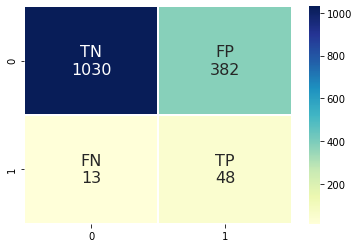

In [63]:
test_error(model_fit = brandomforestBS)

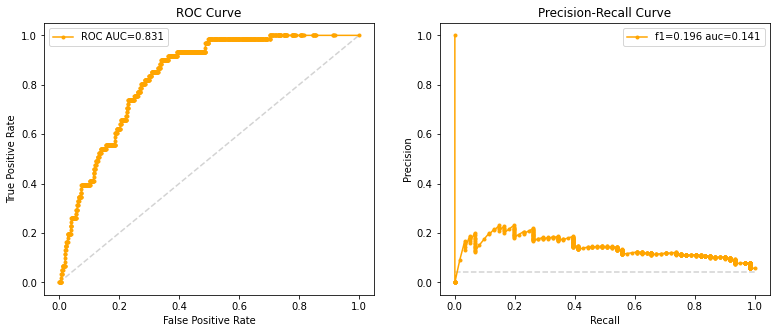

In [64]:
curves(model_fit = brandomforestBS, x_test = x_test, y_test = y_test)

With the new hyperparameters, we achieve a slightly lower true positive rate, but lower false negative rate. The Bayesian search finds quite different parameters from the grid search. In particular, ```tree_depth```is chosen to be at the edge of the chosen range, indicating that it might be better to select it even higher. Notably, the computational cost of doing Bayesian search is much more computationally expensive than the gridsearch, even though the amount of models fitted is much smaller.

### XgBoost

Lastly, we attempt to fit an Xgboost model. We use the implementaition in the ```xgb``` library. XGboost uses many of the same parameters as for random forest, and some additional ones. For a detailed overview, see: https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#id3. Of particular note is the learning rate $\eta$, which is a real number that indicates how much to "learn" from each new tree. We only attempt to tune ```n_estimators```, ```eta``` and ```max_depth```. In addition we use balanced weighting similar to the weighted random forest. We can expect that if the learning rate is large, ```n_estimator``` will be small, and vice versa. In this sense, we would like a large learning rate in order to fit models faster.

The XGBoost classifier is also parallelized, but we choose to parallelize the grid search instead of parallellizing the method fitting.

In [65]:
parameters = {'n_estimators': [10, 30, 50, 100],
              'eta': [0.2, 0.4, 1.0],
              'max_depth': range(1, 10, 1)}

t = time.time()

# Need to manually calculate balanced scale weighting
scale_weight = len(y_train[np.where(y_train == 0)])/len(y_train[np.where(y_train == 1)]) 

boosting = GridSearchCV(estimator = xgb.XGBClassifier(random_state = 23, booster = "gbtree", objective = "binary:logistic",
                                                use_label_encoder = False, eval_metric = "logloss", scale_pos_weight = scale_weight),
                   param_grid = parameters,
                   scoring = metric,
                   n_jobs = 8,
                   cv = 3)
boostingfit = boosting.fit(x_train, y_train)
print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameters:")
print(boosting.best_params_)

Time used for fitting:  19.78454041481018  seconds
Best hyperparameters:
{'eta': 0.2, 'max_depth': 1, 'n_estimators': 50}


Test errors:

accuracy: 0.747
precision: 0.118
recall: 0.787
f1: 0.205


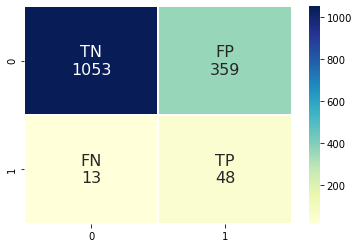

In [66]:
test_error(model_fit = boosting)

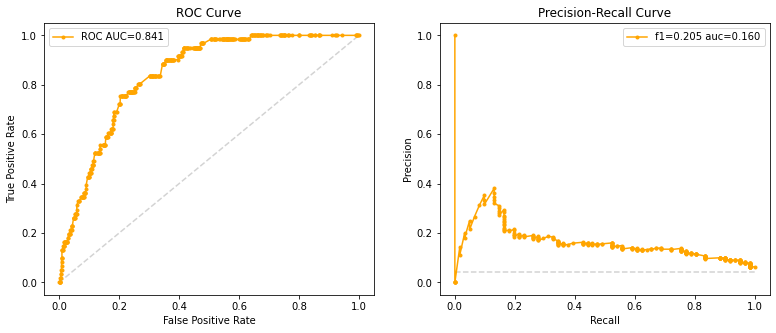

In [67]:
curves(model_fit = boosting, x_test = x_test, y_test = y_test)

Boosting performs even better than balanced random forest, and yield the best results so far. We further attempt to use Bayesian search to tune the parameters further. Here we encounter our first parameter that is a real number, namely the learning parameter $\eta$, which is what Bayesian search is designed for. We look for learning parameters between $0.0001$ and $1.0$. If we look for smaller learning rates, we would need very large ```n_estimators```, which means more computation time, which we want to avoid.

In [68]:
search_space = {'n_estimators': Integer(1,100),
              'eta': Real(1e-4,1e0),
              'max_depth': Integer(1,10)}

t = time.time()

# Need to manually calculate balanced scale weighting
scale_weight = len(y_train[np.where(y_train == 0)])/len(y_train[np.where(y_train == 1)]) 

boostingBS = BayesSearchCV(estimator = xgb.XGBClassifier(random_state = 23, booster = "gbtree",
                                                use_label_encoder = False, eval_metric = "logloss", 
                                                scale_pos_weight = scale_weight),
                   search_spaces = search_space,
                   n_iter = 128, 
                   scoring = metric,
                   n_jobs = 8,
                   n_points = 8,
                   cv = 3)
boostingBSfit = boostingBS.fit(x_train, y_train)
print("Time used for fitting: ", time.time() - t, " seconds")

print("Best hyperparameters:")
print(boostingBS.best_params_)

Time used for fitting:  159.16522479057312  seconds
Best hyperparameters:
OrderedDict([('eta', 0.10916627585410237), ('max_depth', 3), ('n_estimators', 17)])


Test errors:

accuracy: 0.734
precision: 0.111
recall: 0.770
f1: 0.193


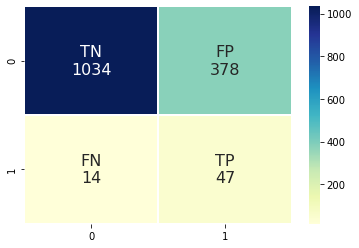

In [69]:
test_error(model_fit = boostingBS)

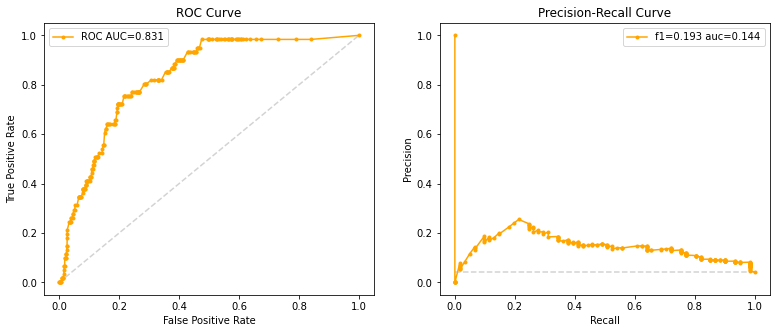

In [70]:
curves(model_fit = boostingBS, x_test = x_test, y_test = y_test)

Bayesian search produces different hyperparameters, but identical results, and a longer computation time. Note that boosting prefers shallower trees, selecting ```max_depth``` equal to $1$ for both gridsearch and 

### Interpreting the random forest results: XAI

Since the predictions from the classification problem we are working with are very important, possibly lifechanging, predictions, the need for interpretability of the model arises. Understanding in which cases the model predicts that someone will have a stroke can help us identify which features or combination of features which are important for early detection and prevention. We will now try to use some of the methods from explainable AI to interpret the results from our random forest methods. We choose to interpret the model from the balanced random forest, as this produced some of the most interesting results.

In [71]:
model= BalancedRandomForestClassifier(**brandomforest.best_params_, criterion = "gini", random_state = 23, bootstrap=True)
modelfit = model.fit(x_train, y_train)
features = df.columns[:-1]

#### Global methods

The first global method we will use is one specific for tree methods. We calculate the gini importance for each feature to find out which features are most important in the building of the trees in the balanced random forest. The importance is computed as the normalized reduction of the gini criterion brought by each feature.

In [72]:
# Importance of each feature
pd.DataFrame(model.feature_importances_.reshape(1, -1), columns=features)

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,govt_job,never_worked,private,self-employed,children,never_smoked,formerly_smoked,smokes,unknown_smoker
0,0.014533,0.472516,0.023057,0.019571,0.032126,0.015907,0.184246,0.150339,0.010989,0.0,0.008138,0.008554,0.003815,0.013242,0.007935,0.015598,0.019433


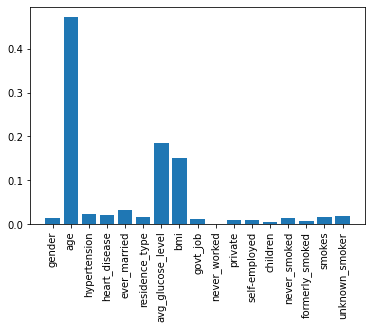

In [73]:
plt.figure()
plt.bar(features, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

We see that the most important features seems to be age, avg_glucose_level and bmi. Somewhat worrisome, the unknown_smoker variable has more importance than the other smoking categories.

For these features we try plotting PD plots to see the marginal effects the features have on the predicted outcome of the balanced random forest. The PD plots shows what the marginal effect on the stroke prediction is for a specific value of a given feature. The assumptions behind using this method is that the features are not correlated. This is not the case. From the correlation plot we saw that age is highly correlated with ever_married, children, bmi and other features, for example. The solution to this problem is using ALE plots instead, but due to time limitations we will not do this in this project. We also plot the individual conditional expectation curves to make sure no effects are hidden by the aggregated PD curve.

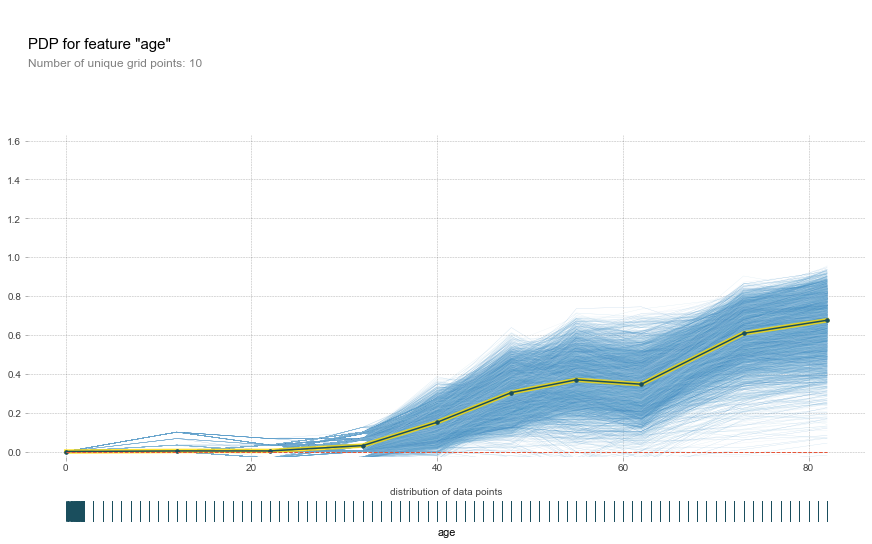

In [74]:
# Age
pdp_age = pdp.pdp_isolate(model=model, dataset=df, model_features=features, feature="age")
fig, axes = pdp.pdp_plot(pdp_age, "age", plot_lines=True, plot_pts_dist=True)

We see that for age, it seems like the general trend is that the chance of having a stroke increases with age in the model. This seems reasonable based on the data. We have data for all the ages, which means that there are no areas where we are more uncertain about the results than others.

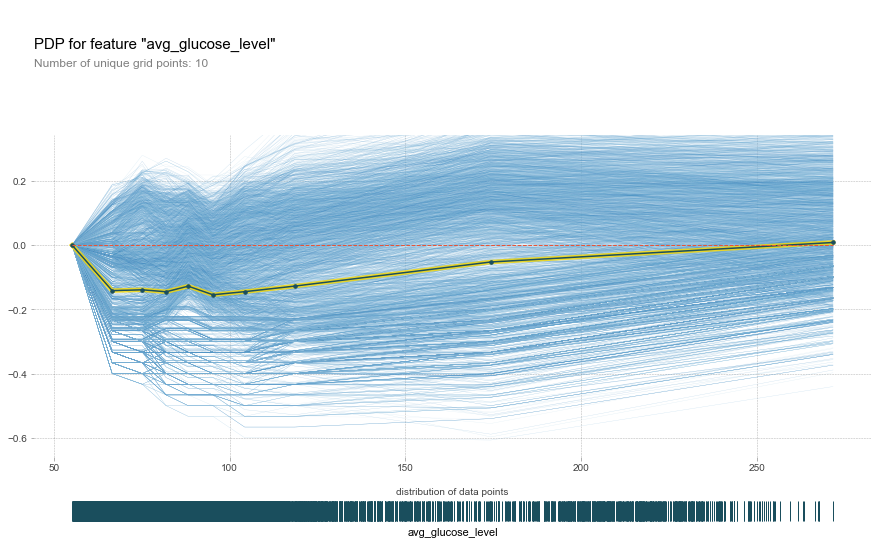

In [75]:
# Avg_glucose_level
pdp_glucose = pdp.pdp_isolate(model=model, dataset=df, model_features=features, feature="avg_glucose_level")
fig, axes = pdp.pdp_plot(pdp_glucose, "avg_glucose_level", plot_lines=True, plot_pts_dist=True)

The PD plot for avg_glucose_levels are harder to gain any information from. It seems that if you have a avg_glocose_level of around 80 you have the lowest chance of having a stroke according to the model, while a value lower or higher than this increases you chances by a little. We have less data at the end of the interval, which means the values here are less certain.

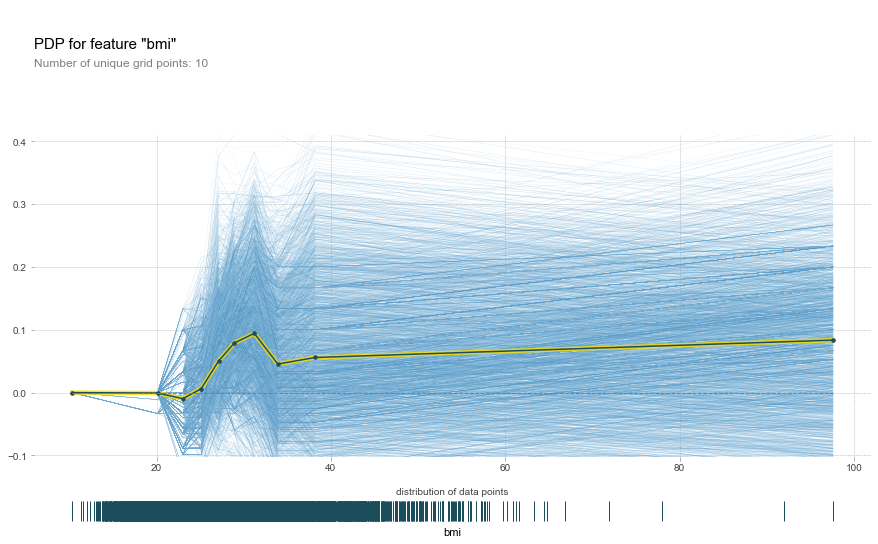

In [76]:
# BMI
pdp_bmi = pdp.pdp_isolate(model=model, dataset=df, model_features=features, feature="bmi")
fig, axes = pdp.pdp_plot(pdp_bmi, "bmi", plot_lines=True, plot_pts_dist=True)

For bmi the general trend seems to be that you have a higher chance of a stroke if you have a high bmi, especially if you have a bmi around $30-35$. For people with a bmi greater than $50$ little can be said from the plot as we have very few data points. For reference, a bmi over $40$ is considered extreme obesity.

#### Local methods

Do to time limitations, we will only use LIME to explain some of the individual predictions of the balanced random forest model. Given more time, we could have also tried including explanations from counterfactual explanations and shapley values. LIME builds a local interpretable model which is a good approximation of the balanced random forest's predictions locally. From this learned method we can get an insight into which features are most important for certain predictions.

We choose 4 observations from the test set, one from each square of the confusion matrix. This way we can try to understand why some of the observations are correctly classified, while others are not. This can help us further understand how the method works and maybe how it can be improved.

Observation no. 51 (true negative): 
True class:  0
Predicted probabilities from model:  [0.84444444 0.15555556]
Figure(432x288)


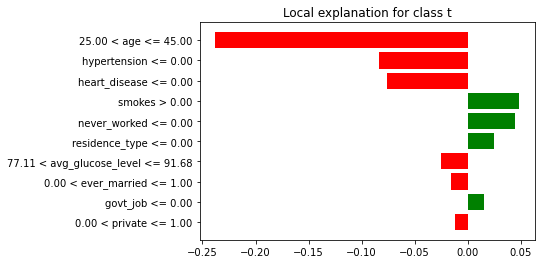

In [77]:
explainer = LimeTabularExplainer(training_data = x_train,
                                 training_labels = y_train,
                                 feature_names = features,
                                 class_names = "stroke",
                                 mode = "classification")

i = 51
obs = x_test[i]
true_class = y_test[i]

print(f"Observation no. {i} (true negative): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(x_test)[i])

exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The first observation is from the class "no stroke", and is correctly predicted by the balanced random forest. We see that the main factors in the prediction is the persons low age, absence of heart disease and absence of hypertension. The model increases the chances of stroke a little because the person smokes and is not in the never_worked class. It is known that smoking is linked with strokes, and interestingly, our model predicts that people who work have higher chance of having a stroke.

Observation no. 99 (false positive): 
True class:  0
Predicted probabilities from model:  [0.13971744 0.86028256]
Figure(432x288)


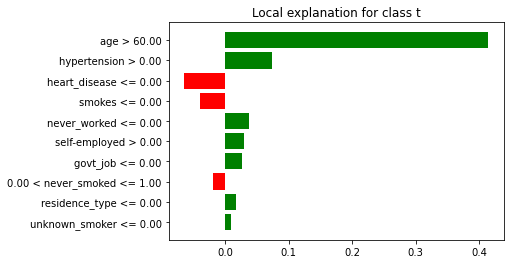

In [78]:
i = 99
obs = x_test[i]
true_class = y_test[i]

print(f"Observation no. {i} (false positive): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(x_test)[i])

exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The second observation is also from the class "no stroke", but is among the observations which are falsely labelled by "stroke" by the balanced random forest. The main reasons is the persons high age and hypertension. We see that the models prediction is based mostly based on age, which is alarming. The only pattern the balanced random forest might have learned is that you have a higher risk of having a stroke if you are old, thus are all old people labeled as having a "stroke", almost independent of other factors.

Observation no. 100 (true positive): 
True class:  1
Predicted probabilities from model:  [0.1150956 0.8849044]
Figure(432x288)


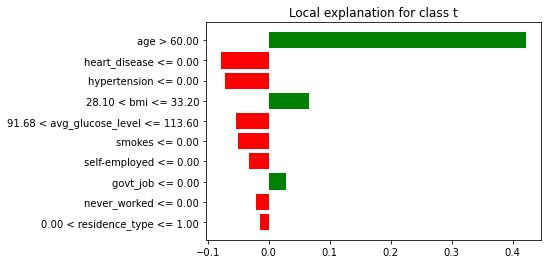

In [79]:
i = 100
obs = x_test[i]
true_class = y_test[i]

print(f"Observation no. {i} (true positive): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(x_test)[i])

exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The third observation is from the class "stroke", and is correctly predicted by the balanced random forest. We see that outside of age, the only features speaking for a stroke is a high bmi and that the person is a former stroker. It does not seem that the model manages to actually capture any other effects than age, and if this does not outbalance the explanation from the feature heart_disease and hypertension, it will totally dominate the prediction.

Observation no. 191 (false negative): 
True class:  1
Predicted probabilities from model:  [0.73172375 0.26827625]
Figure(432x288)


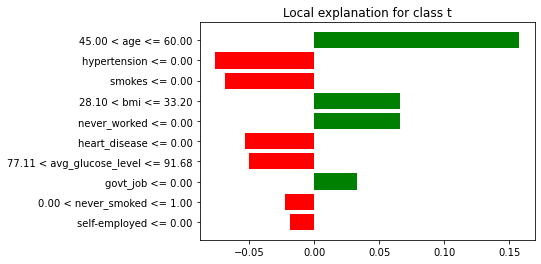

In [80]:
i = 191
obs = x_test[i]
true_class = y_test[i]

print(f"Observation no. {i} (false negative): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(x_test)[i])

exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The last observations is also from the class "stroke", but is falsely predicted by the balanced random forest. We see that the observation is very similar to the third observations, except for the age, which indicates again that age has far to much prediction power in the model. Then again, given the data available, this might be as good as our model gets.